# Canevas pour le TP sur-apprentissage

### <font color='red'>Attention: le piÃ¨ge notebook</font>

  - Il y a une console *cachÃ©e* derriÃ¨re le notebook... Et l'exÃ©cution de chaque bloc change l'Ã©tat courant de la mÃ©moire. Lorsqu'on revient sur le bloc d'avant, ce n'est plus exactement le bloc d'avant puisque les variables globales ne sont plus les mÃªmes.
  

### <font color='blue'>Les trucs importants</font>

  - shift+entrer pour exÃ©cuter un bloc
  - tab pour la complÃ©tion 
  - Configurer matplotlib pour avoir les affichages dans la console au fur et Ã  mesure


In [1]:
# imports nÃ©cessaires dans le cadre du TP
%matplotlib notebook   
# configuration matplotlib (avant l'import)
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

## Import des donnÃ©es 
$$X =  \left[\begin{array}{cccc}
  x_{11}& \ldots &x_{1d}\\  x_{i1}& \ddots &x_{id}
 \\     x_{N1}& \ldots &x_{Nd}
 \end{array}
 \right], \qquad Y =  \left[\begin{array}{cccc}
  y_{1}\\  \vdots \\   y_{N}
 \end{array}
 \right], \qquad x_{ij} \in [0,2], y_i \in \{0, 1, \ldots, 9\}$$
 
 Une image par ligne, associÃ©e Ã  une Ã©tiquette entiÃ¨re. Chaque image est composÃ©e de $d=256$ pixels. 

In [4]:
# nom de fichier (chemin d'accÃ¨s Ã  personnaliser)
#################################################
fname = './usps_verysmall.pkl'
#################################################

data = pkl.load(open(fname,'rb'))
X = data['X']
Y = data['Y']
N,d = X.shape

print(N,d) # vÃ©rification basique
print(Y.shape)

300 256
(300,)


(256,)


<IPython.core.display.Javascript object>


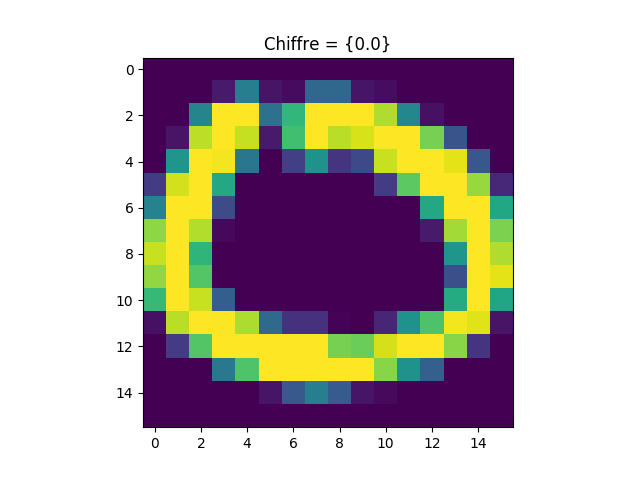

In [7]:
# Affichage d'un chiffre tirÃ© alÃ©atoirement

ind = int(np.random.rand()*N)
print(X[ind].shape)
plt.imshow(np.array(X[ind].reshape(16,16)*128, dtype = int)) # velur entiÃ¨re entre 0 et 255
plt.title("Chiffre = " + str({Y[ind]})) # syntaxe trÃ¨s agrÃ©able pour les chaines formatÃ©e en python 3
plt.show()

# RÃ©partition des donnÃ©es en apprentissage et test

Dans un premier temps, nous travaillons seulement sur les indices. La fonction
    
    ind_app, ind_test = repartition_app_test(N, pc_app)
    N : nombre d'Ã©chantillons dans la base
    pc_app : pourcentage des points Ã  utiliser en apprentissage (entre 0 et 1)
    
doit retourner les jeux d'indices Ã  utiliser pour l'apprentissage et le test. Ces indices auront Ã©tÃ© permutÃ©s alÃ©atoirement en utilisant:

    np.random.permutation(N)
    
On peut par exemple obtenir
[4 8 2 1 0 7 5], [6 3 9] = repartition_app_test(10, 0.7)

Vous dÃ©finirez ensuite xapp, yapp, xtest et ytest

In [14]:
def repartition_app_test(N, pc_app):
    indices = np.random.permutation(N)
    ind_app = indices[:int(np.ceil(pc_app*N))]
    ind_test = indices[int(np.ceil(pc_app*N)):]
    return ind_app, ind_test

pc_app = 0.5 # on part initialement sur une rÃ©partition 50/50
ind_app, ind_test = repartition_app_test(N, pc_app)
xapp = X[ind_app]
yapp = Y[ind_app]
xtest = X[ind_test]
ytest = Y[ind_test]

print("test de somme", N, yapp.shape, ytest.shape)

test de somme 300 (150,) (150,)


# Classification des donnÃ©es par aproche bayesienne

Ce TP porte sur la sÃ©lection de modÃ¨le, c'est Ã  dire le choix de la meilleure solution face Ã  un problÃ¨me donnÃ©. Nous allons comparer des approches vues en TME 3 et des approches discrimitnantes.

Parmi les approches discriminantes, nous chercherons Ã  optimiser les hyper-paramÃ¨tres afin d'optenir des performances maximales.

## ModÃ©lisation (naÃ¯ve) de Bernoulli

Transformation des donnÃ©es pour avoir des pixels binaires:
$$Xb =  \left[\begin{array}{cccc}
  xb_{11}& \ldots &xb_{1d}\\  xb_{i1}& \ddots &xb_{id}
 \\     xb_{N1}& \ldots &xb_{Nd}
 \end{array}
 \right], \qquad Y =  \left[\begin{array}{cccc}
  y_{1}\\  \vdots \\   y_{N}
 \end{array}
 \right], \qquad x_{ij} \in \color{red}{\{0,1\}}, y_i \in \{0, 1, \ldots, 9\}$$

### Modification des donnÃ©es: chaque pixel

In [15]:
# binariser X
Xb = np.where(X >0, 1., 0.)
# SÃ©paration des donnÃ©es apprentissage / test
xbapp = Xb[ind_app]
xbtest = Xb[ind_test]

### Fonctions d'apprentissage et d'infÃ©rence

    theta = learnBernoulli (X,Y)
    X : donnÃ©es d'apprentissage (un exemple par ligne)
    Y : Etiquettes entiÃ¨res correspondantes
    theta : autant de modÃ¨les que de Y diffÃ©rent
            un modÃ¨le par ligne
    
    p = logpobsBernoulli(X, theta)
    X : donnÃ©es Ã  classifier (un exemple par ligne)
    theta : jeux de paramÃ¨tres issus de la fonction prÃ©cÃ©dente
    p : log-vraisemblance de chacune des classes pour chacun des exemples
    
$$p =  \left[\begin{array}{cccc}
  p(x_{1} | \theta_1) & p(x_{2} | \theta_1) &  \ldots &p(x_{N} | \theta_1)\\ 
  p(x_{1} | \theta_2) & p(x_{2} | \theta_2) &  \ldots &p(x_{N} | \theta_2)\\
  \vdots &\vdots &\vdots &\vdots \\ 
  p(x_{1} | \theta_C) & p(x_{2} | \theta_C) &  \ldots &p(x_{N} | \theta_C)\\
 \end{array}
 \right]$$

In [64]:
################################################################################
# Modelisation bernoulli
def learnBernoulli (X,Y): # construction
    theta = [(X[Y==y].mean(0)) for y in np.sort(np.unique(Y))]
    return np.array(theta)

def logpobsBernoulli(X, theta):
    seuil = 1e-4
    theta = np.maximum(np.minimum(1-seuil, theta),seuil)
    logp = [[ (x*np.log(mod)+(1-x)*np.log(1-mod)).sum() for x in X] for mod in theta ]
    return np.array(logp)

################################################################################
# Apprentissage d'un modÃ¨le & calcul des vraisemblance des observations
# reflÃ©chir Ã  un moyen simple de retrouver la classe Ã  partir du tableau de probabilitÃ©s

theta = learnBernoulli ( xbapp, yapp )
logp  = logpobsBernoulli(xbapp, theta)
logpT = logpobsBernoulli(xbtest, theta)

# Si le code ci-dessus est difficile Ã  comprendre, vous pouvez visualiser les modÃ¨les
plot = False # False
if plot:
    plt.figure()
    plt.imshow(np.array(theta[0].reshape(16,16)*255, dtype = int))
    plt.show()

################################################################################
# Inference

ypred  = logp.argmax(0)
ypredT = logpT.argmax(0)

################################################################################
# Calcul de performances => Proposition d'une solution compacte

print("Bernoulli : Taux bonne classification en apprentissage : ",\
      np.where(ypred != yapp, 0.,1.).mean())
print("Bernoulli : Taux bonne classification en test : ",\
      np.where(ypredT != ytest, 0.,1.).mean())

[0 0 8 3 3 8 6 6 8 9 6 1 4 6 1 3 0 1 6 2 1 1 0 6 3 5 9 6 5 2 6 7 0 8 2 2 8
 4 4 6 6 5 5 9 5 3 5 3 3 8 6 8 1 8 2 0 6 5 8 9 8 6 6 1 8 5 5 1 2 6 8 8 8 5
 3 0 3 9 6 1 8 8 3 1 5 8 5 0 9 3 7 6 8 6 0 6 0 8 4 2 5 6 6 6 3 4 8 6 6 8 0
 3 6 8 5 8 0 8 0 5 2 8 0 8 8 7 5 6 7 3 8 5 8 6 3 8 8 2 5 4 4 7 5 7 0 1 5 5
 8 8]
[7. 9. 1. 6. 1. 1. 2. 3. 0. 0. 5. 1. 0. 8. 9. 8. 7. 9. 2. 7. 0. 0. 0. 1.
 4. 6. 7. 5. 9. 4. 1. 6. 2. 6. 7. 4. 4. 1. 5. 6. 3. 7. 6. 1. 6. 0. 3. 7.
 9. 3. 3. 2. 0. 3. 5. 5. 1. 7. 8. 2. 5. 1. 1. 7. 4. 2. 0. 2. 1. 6. 3. 0.
 6. 0. 2. 9. 7. 0. 1. 1. 0. 2. 3. 6. 0. 5. 4. 3. 3. 3. 1. 9. 8. 6. 3. 8.
 0. 7. 0. 4. 7. 6. 8. 2. 8. 9. 0. 2. 1. 5. 5. 5. 0. 0. 1. 1. 0. 6. 7. 0.
 0. 2. 1. 5. 9. 1. 0. 1. 2. 7. 6. 1. 7. 6. 8. 1. 3. 4. 1. 5. 0. 1. 0. 4.
 4. 8. 2. 3. 7. 9.]
Bernoulli : Taux bonne classification en apprentissage :  0.43333333333333335
Bernoulli : Taux bonne classification en test :  0.1


## ModÃ©lisation gÃ©omÃ©trique

Calcul des profils de chiffres.
Transformation des donnÃ©es pour avoir, sur chaque ligne, la position du premier pixel allumÃ©. Au pire, on considÃ¨re que le pixel 17 (virtuel) est toujours allumÃ©.

$$X =  \left[\begin{array}{cccc}
  xg_{1}\\  xg_{i}
 \\     xg_{N}
 \end{array}
 \right], \qquad Y =  \left[\begin{array}{cccc}
  y_{1}\\  \vdots \\   y_{N}
 \end{array}
 \right], \qquad x_{ij} \in \color{red}{\{1,2,\ldots,17\}}, y_i \in \{0, 1, \ldots, 9\}$$

In [17]:
################################################################################
# modelisation geometrique
def transfoProfil(X):
    x2 = []
    for x in X:
        ind = np.where(np.hstack((x.reshape(16, 16), np.ones((16,1))))>0)
        x2.append( [ind[1][np.where(ind[0] == i)][0] for i in range(16)])
    return np.array(x2)

################################################################################
# fonctions d'apprentissage / infÃ©rence identique (en usage) Ã  celles de Bernoulli

def learnGeom ( X,Y):
    seuil = 1e-4
    theta = [(1./X[Y==y].mean(0)) for y in np.sort(np.unique(Y))]
    theta = np.array(theta)
    return np.maximum(np.minimum(1-seuil, theta),seuil)
# attention aux lignes tjs vides 

def logpobsGeom(X, theta):
    logp = [[( (x-1) * np.log(1 - mod) + np.log(mod)).sum() for x in X] for mod in theta]
    return np.array(logp)

Xg = transfoProfil(X)

# rÃ©partition apprentissage / test
# apprentissage
# Ã©valuation 

In [29]:
# rÃ©partition apprentissage / test
i_app, i_test = repartition_app_test(N, pc_app)
xapp = Xg[ind_app]
yapp = Y[ind_app]
xtest = Xg[ind_test]
ytest = Y[ind_test]

In [30]:
# apprentissage
theta = learnGeom(xapp, yapp)
logp = logpobsGeom(xapp, theta)
logpT = logpobsGeom(xtest, theta)

In [31]:
# Ã©valuation 
ypred  = logp.argmax(0)
ypredT = logpT.argmax(0)

################################################################################
# Calcul de performances => Proposition d'une solution compacte

print("Geometrique : Taux bonne classification en apprentissage : ",\
      np.where(ypred != yapp, 0.,1.).mean())
print("Geometrique : Taux bonne classification en test : ",\
      np.where(ypredT != ytest, 0.,1.).mean())

Geometrique : Taux bonne classification en apprentissage :  0.62
Geometrique : Taux bonne classification en test :  0.62


## ModÃ©lisation Gaussienne naÃ¯ve

Correction du TME 3... En 10 lignes :)

In [32]:
###############################################################################
# ModÃ©lisation gaussienne

def woZeros(x): # fonction de suppression des 0 (remplacement par un seuil)
    #y = np.where(x==0., 1e-6, x) # plus logique mais moins performant !
    y = np.maximum(x, 1e-2) # seuillage de toutes les proba
    return y

def learnGauss ( X,Y): # moyenne et variances des 10 classes de donnÃ©es
    theta = [(X[Y==y].mean(0),woZeros(X[Y==y].var(0))) for y in np.unique(Y)]
    return np.array(theta)

def logpobsGauss(X, theta): # vraisemblance de X pour les 10 modÃ¨les
    logp = [[-0.5*np.log(mod[1,:] * (2 * np.pi )).sum() + \
             -0.5 * ( ( x - mod[0,:] )**2 / mod[1,:] ).sum () for x in X] for mod in theta ]
    return np.array(logp)

###############################################################################
# Apprentissage / infÃ©rence / test
i_app, i_test = repartition_app_test(N, pc_app)
xapp = X[ind_app]
yapp = Y[ind_app]
xtest = X[ind_test]
ytest = Y[ind_test]

theta = learnGauss(xapp, yapp)
logp = logpobsGauss(xapp, theta)
logpT = logpobsGauss(xtest, theta)

ypred  = logp.argmax(0)
ypredT = logpT.argmax(0)

################################################################################
# Calcul de performances => Proposition d'une solution compacte

print("Gaussienne : Taux bonne classification en apprentissage : ",\
      np.where(ypred != yapp, 0.,1.).mean())
print("Gaussienne : Taux bonne classification en test : ",\
      np.where(ypredT != ytest, 0.,1.).mean())

Gaussienne : Taux bonne classification en apprentissage :  0.9333333333333333
Gaussienne : Taux bonne classification en test :  0.7666666666666667


# Passage aux approches discriminantes

DÃ©finition d'un classifieur Perceptron correspondant Ã  la minimisation du coÃ»t suivant:
$$ f( \mathbf x_{i}) = \sum_{j} x_{ij} w_{j} , \qquad C =  \sum_{i=1}^{N} C_i =  \sum_{i=1}^{N}  (- y_{i} \mathbf x_{i} \mathbf w)_{+},\qquad (\alpha)_+ = \left\{ 
\begin{array}{cccc}
 \alpha & \mbox{ si } \alpha > 0 \\ 0 & \mbox{ sinon}
 \end{array}
 \right. $$
 
Nous utiliserons l'algorithme de descente de gradient stochastique:
  - Initialiser $\mathbf w_{0} = [0, \ldots, 0]$
  - Bouclage jusqu'Ã  convergence (ou sur un nombre d'itÃ©rations)
     - Tirage alÃ©atoire d'un Ã©chantillon $i$
     - Si $y_{i} \mathbf x_{i} \mathbf w \le 0$
        - Calcul de  $\nabla_{\mathbf w}  C_{i} = -y_{i} \mathbf x_{i}$
        - MAJ: $\mathbf w^{t+1} = \mathbf w^{t} - \epsilon \nabla_{\mathbf w} C_{i}$

DÃ©finir la fonction:
    
    w = perceptron(x, y, eps = 1e-5, niter = 20000)
    x : donnÃ©es d'apprentissage
    y : Ã©tiquettes d'apprentissage binaires dÃ©finies en -1 / 1
    
On se rappelera que le calcul de $f(\mathbf x)$ s'effectue comme suit:

    yhat = x.dot(w)

In [46]:
# algorithme du perceptron
def perceptron(x, y, eps = 1e-5, niter = 20000):
    l = len(x[0])
    indmax = len(x)
    w = np.zeros(l)
    for i in range(niter):
        index = np.random.randint(indmax)
        if y[index]*(np.dot(x[index], w)) <=0:
            D = -y[index]*x[index]
            w = w - eps*D
    return w

In [47]:
# Application de l'algorithme du perceptron sur nos donnÃ©es pour la distinction des 1 et 2:
ind12,  = np.where((yapp > 0) & (yapp <3))
yapp12  = yapp[ind12]
yapp12  = np.where(yapp12 > 1 , -1., 1.) # transformation des Ã©tiquettes en {-1, 1}
xapp12  = xapp[ind12]

w = perceptron(xapp12, yapp12)

#########################################################
# Attention Ã  avoir une sortie en -1 / 1 (ou alors changer le test dans le calcul dessous)
ypred = np.where(xapp12.dot(w) >= 0, 1., -1.)

print("Percep : Taux bonne classification en apprentissage : ",np.where(ypred != yapp12, 0.,1.).mean())


Percep : Taux bonne classification en apprentissage :  1.0


Modifier la fonction du perceptron pour retourner l'ensemble des $\mathbf w$ mis Ã  jour dans l'algorithme. Tracer sur une figure l'Ã©volution de la fonction de coÃ»t (et Ã©ventuellement le taux de bonne classification). 

<IPython.core.display.Javascript object>


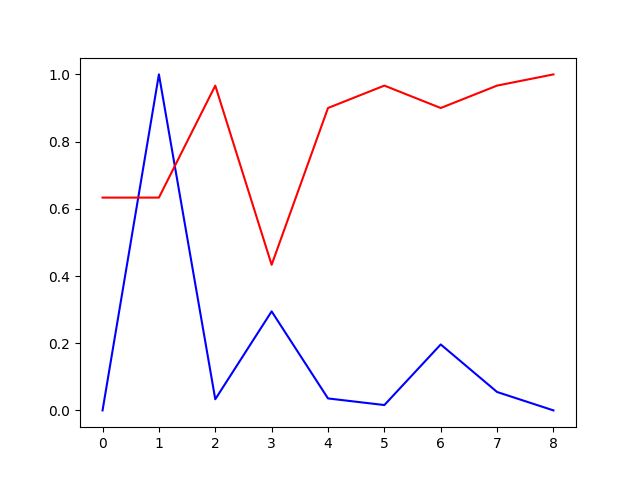

In [54]:
# algorithme du perceptron
def perceptronh(x, y, eps = 5e-6, niter = 20000):
    l = len(x[0])
    indmax = len(x)
    w = np.zeros(l)
    allw = [w]
    for i in range(niter):
        index = np.random.randint(indmax)
        if y[index]*(np.dot(x[index], w)) <=0:
            D = -y[index]*x[index]
            w = w - eps*D
            allw.append(w)
    return w,allw

w,allw = perceptronh(xapp12, yapp12)


def positif(a):
    if a > 0:
        return a
    return 0


c = np.zeros(len(allw)) # tous les couts
p = np.zeros(len(allw)) # tous les pourcentages de bonne classif
for i,w in enumerate(allw):
    for j in range(len(xapp12)):
        c[i]+= positif(-yapp12[j]*(xapp12[j].dot(w)))
    p[i] = np.where(np.where(xapp12.dot(w) >= 0, 1., -1.) != yapp12, 0.,1.).mean()
    # calcul des indicateurs ci-dessus
    
plt.figure()
plt.plot(c/np.max(c),'b') # affichage normalisÃ© => plus facile Ã  lire
plt.plot(p/np.max(p),'r')
plt.show()

## Passage au multiclasse

Pour passer d'un classifieur binaire dans $\{-1,1\}$ Ã  un classifieur dans $C$ classes, nous allons dÃ©finir $C$ classifieurs appris indÃ©pendamment:
  - classifieur 1 = classe 1 vs toutes les autres (=-1)
  - classifieur 2 = classe 2 vs toutes les autres (=-1)
  - ...
  
Pour les classifieurs linÃ©aires, l'idÃ©e est de concatÃ©ner tous les poids des $C$ classifieurs dans une matrice W:

$$W \in \mathbb R^{d,C} =  \left[\begin{array}{cccc}
  \mathbf w_1^T &  \mathbf w_2^T & \ldots & \mathbf w_C^T \\
 \end{array}
 \right], \qquad \mathbf{\hat y} = \mathbf x \cdot W \in \mathbb R^{C}$$

Le code fourni ci-dessous devrait fonctionner avec votre perceptron. 


In [55]:
# passage au multiclasse (formulation fonctionnelle)

def classifMC(classif, x, y, **kargs): 
    # classif = passage d'une fonction
    # passage des arguments du classifieur dans **kargs
    N,d = x.shape
    classes = np.sort(np.unique(y)) # extraction de toutes les classes
    W = np.zeros((d,len(classes)))  # init W
    for i,target in enumerate(classes): # pour toutes les classes
        ytmp = np.where(y==target, 1, -1)
        W[:,i] = classif(x,ytmp, **kargs) # restitution des paramÃ¨tres
    return W

In [59]:
W = classifMC(perceptron, xapp, yapp, niter=30000)

# retrouver la formule d'infÃ©rence
ypred  = (xapp.dot(W)).argmax(1)
ypredT = (xtest.dot(W)).argmax(1)

print("Percep : Taux bonne classification en apprentissage : ",\
      np.where(ypred != yapp, 0.,1.).mean())
print("Percep : Taux bonne classification en test : ",\
      np.where(ypredT != ytest, 0.,1.).mean())

Percep : Taux bonne classification en apprentissage :  1.0
Percep : Taux bonne classification en test :  0.8133333333333334


## StabilitÃ© des rÃ©sultats

RÃ©peter K fois la sÃ©paration des donnÃ©es (apprentissage / test), apprentissage d'un modÃ¨le (Bernoulli, Perceptron ou les deux), Ã©valuation des performances en test...

La stabilitÃ© des performances n'est pas trÃ¨s satisfaisante.

In [61]:
# Etude de stabilitÃ©
# binariser X
Xb = np.where(X >0, 1., 0.)
pc_app = 0.5
K = 10
for k in range (K):
    ind_app, ind_test = repartition_app_test(N, pc_app)
    # rÃ©partition des donnÃ©es, app, Ã©val, affichage...
    xbapp = Xb[ind_app]
    xbtest = Xb[ind_test]
    
    theta = learnBernoulli ( xbapp, yapp )
    logp  = logpobsBernoulli(xbapp, theta)
    logpT = logpobsBernoulli(xbtest, theta)
    
    ypred  = logp.argmax(0)
    ypredT = logpT.argmax(0)

    ################################################################################
    # Calcul de performances => Proposition d'une solution compacte

    print("Bernoulli : Taux bonne classification en apprentissage : ",\
          np.where(ypred != yapp, 0.,1.).mean())
    print("Bernoulli : Taux bonne classification en test : ",\
          np.where(ypredT != ytest, 0.,1.).mean())

Bernoulli : Taux bonne classification en apprentissage :  0.44666666666666666
Bernoulli : Taux bonne classification en test :  0.11333333333333333
Bernoulli : Taux bonne classification en apprentissage :  0.5333333333333333
Bernoulli : Taux bonne classification en test :  0.10666666666666667
Bernoulli : Taux bonne classification en apprentissage :  0.4533333333333333
Bernoulli : Taux bonne classification en test :  0.08666666666666667
Bernoulli : Taux bonne classification en apprentissage :  0.4866666666666667
Bernoulli : Taux bonne classification en test :  0.08666666666666667
Bernoulli : Taux bonne classification en apprentissage :  0.4666666666666667
Bernoulli : Taux bonne classification en test :  0.12666666666666668
Bernoulli : Taux bonne classification en apprentissage :  0.5266666666666666
Bernoulli : Taux bonne classification en test :  0.14
Bernoulli : Taux bonne classification en apprentissage :  0.52
Bernoulli : Taux bonne classification en test :  0.08666666666666667
Bernou

# Evaluation en validation croisÃ©e, sÃ©lection de modÃ¨les

La validation croisÃ©e consiste Ã  
1. dÃ©finir K blocs de tailles proches dans les donnÃ©es d'apprentissage
1. utiliser K-1 blocs pour l'apprentissage des modÃ¨les et 1 bloc pour le test

La division en K blocs est fastidieuse, surtout si on souhaite prÃ©server les Ã©quilibres entre classes... Le code vous est fourni ci-dessous.

In [65]:
# mise en place de la validation croisÃ©e
n_fold = 6; # paramÃ¨tre critique : nb de blocs Ã  dÃ©finir

# OPT : mÃ©lange de toutes les donnÃ©es (X et Y)
# par classe faire 10 tas Ã  peu prÃ¨s de mÃªmes tailles
yu = np.sort(np.unique(Y))
ind_cv_y = [np.array_split(np.where(Y == y)[0], n_fold) for y in yu]
# fusion de tous les indices par fold
ind_cv = [np.concatenate([ind_cv_y[c][fold] for c in range(len(yu))]) for fold in range(n_fold)]

def make_app_test(X, Y, i): # attention, beaucoup de variables globales dedans...
    itest  = ind_cv[i]
    iapp = np.concatenate([ind_cv[fold] for fold in range(n_fold) if fold != i])
    return X[iapp], Y[iapp], X[itest], Y[itest]

#### A vous d'utiliser la fonction ci-dessus pour Ã©valuer vos modÃ¨les

In [69]:
bern = 0
bernT = 0
geom = 0
geomT = 0
gauss = 0
gaussT = 0
per = 0
perT = 0
for i in range(n_fold):
    Xapp, Yapp, Xtest, Ytest = make_app_test(X, Y, i)
    #Bernouilli
    Xb = np.where(Xapp >0, 1., 0.)
    XbT =np.where(Xtest >0, 1., 0.)
    theta = learnBernoulli (Xb, Yapp )
    logp  = logpobsBernoulli(Xb, theta)
    logpT = logpobsBernoulli(XbT, theta)
    
    ypred  = logp.argmax(0)
    ypredT = logpT.argmax(0)
    bern += np.where(ypred != Yapp, 0.,1.).mean()
    bernT += np.where(ypredT != Ytest, 0.,1.).mean()
    #geometrique
    Xg = transfoProfil(Xapp)
    XgT = transfoProfil(Xtest)
    
    theta = learnGeom(Xg, Yapp)
    logp = logpobsGeom(Xg, theta)
    logpT = logpobsGeom(XgT, theta)
    
    ypred  = logp.argmax(0)
    ypredT = logpT.argmax(0)
    geom += np.where(ypred != Yapp, 0.,1.).mean()
    geomT += np.where(ypredT != Ytest, 0.,1.).mean()
    #gaussienne
    theta = learnGauss(Xapp, Yapp)
    logp = logpobsGauss(Xapp, theta)
    logpT = logpobsGauss(Xtest, theta)

    ypred  = logp.argmax(0)
    ypredT = logpT.argmax(0)
    
    gauss += np.where(ypred != Yapp, 0.,1.).mean()
    gaussT += np.where(ypredT != Ytest, 0.,1.).mean()
    #perceptron
    W = classifMC(perceptron, Xapp, Yapp, niter=30000)

    ypred  = (Xapp.dot(W)).argmax(1)
    ypredT = (Xtest.dot(W)).argmax(1)
    
    per += np.where(ypred != Yapp, 0.,1.).mean()
    perT +=np.where(ypred != Ytest, 0.,1.).mean()
    
print("Bernoulli : Taux bonne classification en apprentissage : ",\
        bern/n_fold)
print("Bernoulli : Taux bonne classification en test : ",\
        bernT/n_fold)
print("Geometrique : Taux bonne classification en apprentissage : ",\
        geom/n_fold)
print("Geometrique : Taux bonne classification en test : ",\
        geomT/n_fold)
print("Gaussienne : Taux bonne classification en apprentissage : ",\
        gauss/n_fold)
print("Gaussienne : Taux bonne classification en test : ",\
        gaussT/n_fold)
print("Perceptron : Taux bonne classification en apprentissage : ",\
        per/n_fold)
print("Perceptron : Taux bonne classification en test : ",\
        perT/n_fold)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


Bernoulli : Taux bonne classification en apprentissage :  0.9027206493670947
Bernoulli : Taux bonne classification en test :  0.8272970826750751
Geometrique : Taux bonne classification en apprentissage :  0.6454428819752042
Geometrique : Taux bonne classification en test :  0.6052772351675385
Gaussienne : Taux bonne classification en apprentissage :  0.901986247807613
Gaussienne : Taux bonne classification en test :  0.7789938492982239
Perceptron : Taux bonne classification en apprentissage :  1.0
Perceptron : Taux bonne classification en test :  0.0


## DÃ©finition d'un modÃ¨le de perceptron avec marge et rÃ©gularisation

$$ f( \mathbf x_{i}) = \sum_{j} x_{ij} w_{j} , \qquad C =  \sum_{i=1}^{N}  ({\color{magenta} m -} y_{i} \mathbf x_{i} \mathbf w)_{+} + {\color{blue}{ \lambda \|\mathbf w\|^{2}}}$$

Comme nous l'avons vus en cours, nous allons introduire diffÃ©rents paramÃ¨tres pour amÃ©liorer notre perceptron:
1. Un paramÃ¨tre de marge pour que les points autour de $f( \mathbf x_{i}) = 0$ soient considÃ©rÃ©s comme mal classÃ©s et provoquent une mise Ã  jour des poids du classifieurs
1. Un paramÃ¨tre de rÃ©gularisation pour se focaliser sur les dimensions les plus importantes et pÃ©naliser les poids les moins importants
  - Montrer que la prise en compte du terme de rÃ©gularisation correspond Ã  un gradient de la forme:
  $$\nabla_{\mathbf w} = 2 \mathbf w$$
  - ... Et que la mise Ã  jour en descente de gradient correspond Ã 
  $$ \mathbf w \leftarrow \mathbf w * (1 - \lambda')$$

Donner le code de ce nouveau perceptron (svm linÃ©aire), qui attend donc plus de paramÃ¨tres.
    
    w = svmlin(x, y, regul = 1e-5, margin=.15, eps = 5e-6, niter = 20000)

In [ ]:
def svmlin(x, y, regul = 1e-5, margin=.15, eps = 2e-5, niter = 20000):
    # A complÃ©ter
    return w

## SÃ©lection de modÃ¨le

La sÃ©lection de modÃ¨le consiste Ã  dÃ©terminer quels sont les paramÃ¨tres optimaux associÃ©s Ã  un modÃ¨le. Cette sÃ©lection sera effectuÃ©e sur critÃ¨re de validation croisÃ©e. Nous proposons de faire un *grid search* sur le paramÃ¨tre de rÃ©gularisation, sur les valeurs suivantes:

    reg = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 0]

On va donc d'une rÃ©gulartisation forte Ã  une rÃ©gularisation nulle. 
1. Trouver la valeur optimale des paramÃ¨tres
1. Etudier les Ã©carts entre performances en apprentissage et performances en test
1. La performance obtenue sur le meilleur modÃ¨le est-elle un estimateur dÃ©biaisÃ© de la performance en test?

In [ ]:
# SÃ©lection de modÃ¨le

# Comparaison significative entre modÃ¨les

Une fois que vous avez appliquÃ© la procÃ©dure de validation croisÃ©e sur deux classifieurs, vous obtenez deux tableaux de performances:
$$\left[\begin{array}{cccc}
P_{mod1} = & p_{11} & \ldots & p_{1K} \\
P_{mod2} = & p_{21} & \ldots & p_{2K} \\
 \end{array}
 \right]$$
 
 Nous proposons ensuite d'utiliser la mÃ©thodologie d'un de nos exercice de TD:
 
 Soit $X_1, X_2, \ldots, X_{n}$ une suite de variables alÃ©atoires rÃ©elles dÃ©finies sur le mÃªme espace de probabilitÃ©, indÃ©pendantes et identiquement distribuÃ©es suivant la mÃªme loi $X$, de moyenne $\mu$. Lorsque la variance de $D$ est inconnue, il faut passer du TCL au test de Student, qui dit que la variable  

$$T={\frac  {\bar X - \mu}{{\sigma_{x}/\sqrt  {n}}}}, \qquad \sigma_{d} = \sqrt{\frac{\sum_{i} (x_{i} - \bar x)^{2}}{n-1}}$$
suit une loi de Student Ã  $n-1$ degrÃ©s de libertÃ©. $\sigma_{d}$ correspond Ã  l'estimation non biaisÃ©e de l'Ã©cart type de $X$.

Remarque: vous pouvez chercher les valeurs limites de la loi de Student dans votre fascicule de TD ou utiliser:

    alpha : niveau de confiance
    ddl : nb dÃ©grÃ©s de libertÃ©
    from scipy import stats
    stats.t.ppf(alpha, df=ddl)